# Determining Equivalance Relative Spectral Response

In [83]:
%matplotlib inline
import numpy as np
import math
from scipy.interpolate import UnivariateSpline
from scipy import signal
from scipy import ndimage
from scipy import stats
from scipy.stats import norm
import emd # From - https://github.com/andreasjansson/python-emd
import pandas
import plotly

import numpy as np
from skimage import data, img_as_float
from skimage import exposure
from matplotlib import pyplot as plt

import folium
from IPython.display import display
import geopandas
from shapely.geometry import mapping
from shapely.geometry import MultiPolygon
import rasterio
import shapely.geometry
import shapely.ops
from functools import partial
import pyproj
from datacube.model import CRS

from datacube.storage import masking
import pandas

plotly.offline.init_notebook_mode()

import datacube
dc = datacube.Datacube(app='dc-example')

In [2]:
def plotallbands(sensor):
    plotlydatalist = []
    for key in sensordict[sensor].keys():
        plotlydatalist.append({"x": sensordict[sensor][(key)].wavelength,\
                                "y": sensordict[sensor][(key)].rsr,"name": (key)})

    plotly.offline.iplot({ "data": plotlydatalist,"layout": {"title": sensor}})

In [3]:
def reshape_interpolate(start, stop, samples, npdatatype, input1dwavelength,input1drsr,wlscalefactor):
    wavelength = np.linspace(start,stop,samples, dtype=float)
    rsr = np.nan_to_num(np.interp(wavelength,input1dwavelength*wlscalefactor, input1drsr))
    return wavelength, rsr

In [4]:
# Synthetic band from centre wavelength and spline roots for fwhm
def synthetic_rsr(samples, bandcentrewavelength,fwhm):
    #returns 1d normalized relative spectral response assuming normal distibution
    sigma = fwhm / 2.35
    normdist = stats.norm.pdf(samples, loc=bandcentrewavelength, scale=sigma)
    response = (normdist - normdist.min())/(normdist.max() - normdist.min())
    
    return(response)

## What does our datacube have?

In [5]:
dc.list_measurements()

aliases  \
product               measurement                                       
h8_ahi_brf_granule    03_500                                 [band_3]   
                      01_1000                                [band_1]   
                      02_1000                                [band_2]   
                      03_1000                                [band_3]   
                      04_1000                                [band_4]   
                      01_2000                                [band_1]   
                      02_2000                                [band_2]   
                      03_2000                                [band_3]   
                      04_2000                                [band_4]   
                      05_2000                                [band_5]   
                      06_2000                                [band_6]   
h8_ahi_obs_granule    01_2000                                [band_1]   
                      02_2000                                [band_2]   
                      03_2000                                [band_3]   
                      04_2000                                [band_4]   
                      05_2000                                [band_5]   
                      06_2000                                [band_6]   
                      07_2000                                [band_7]   
                      08_2000                                [band_8]   
                      09_2000                                [band_9]   
                      10_2000                               [band_10]   
                      11_2000                               [band_11]   
                      12_2000                               [band_12]   
                      13_2000                               [band_13]   
                      14_2000                               [band_14]   
                      15_2000                               [band_15]   
                      16_2000                               [band_16]   
h8_ahi_solar_granule  SOLAR_1000                                  NaN   
                      SOLAR_2000                                  NaN   
                      SOLAR_500                                   NaN   
...                                                               ...   
modis_mcd43a4_tile    Nadir_Reflectance_Band1                     NaN   
                      Nadir_Reflectance_Band2                     NaN   
                      Nadir_Reflectance_Band3                     NaN   
                      Nadir_Reflectance_Band4                     NaN   
                      Nadir_Reflectance_Band5                     NaN   
                      Nadir_Reflectance_Band6                     NaN   
                      Nadir_Reflectance_Band7                     NaN   
s1a_gamma0_scene      vh_gamma0                 [band_01, B01, Band1]   
                      vv_gamma0                 [band_02, B02, Band2]   
s2a_level1c_albers_20 veg1                      [band_05, B05, Band5]   
                      veg2                      [band_06, B06, Band6]   
                      veg3                      [band_07, B07, Band7]   
                      snowicecloud2            [band_12, B12, Band12]   
                      veg4                     [band_8A, B8A, Band8A]   
s2a_level1c_albers_60 aerosol                   [band_01, B01, Band1]   
                      water_vapour              [band_09, B09, Band9]   
                      cirrus                   [band_10, B10, Band10]   
s2a_level1c_granule   01                        [band_01, B01, Band1]   
                      02                        [band_02, B02, Band2]   
                      03                        [band_03, B03, Band3]   
                      04                        [band_04, B04, Band4]   
                      05                        [band_05, B05, Band5]   
                      06                       

In [6]:
df = dc.list_measurements()

In [7]:
sensordict = {}

In [8]:
for product in dc.index.products.get_all():
  sensor = product.metadata.instrument
  measurements = product.measurements
  sensordict[(product.name)] = {}

  for name, measurement in measurements.items():
    if 'spectral_definition' in measurement:
        sensordict[(product.name)][name] = pandas.DataFrame({'wavelength': measurements[(name)]['spectral_definition']['wavelength'], 'rsr': measurements[(name)]['spectral_definition']['response']})

## User Reference Band

In [9]:
# https://en.wikipedia.org/wiki/Blue 450–495 nm
# https://en.wikipedia.org/wiki/Green 495–570 nm
# https://en.wikipedia.org/wiki/Red 620–740 nm
# https://en.wikipedia.org/wiki/Infrared 750–1400 nm
sensor = 'user_reference'
sensordict[sensor] = {}

wavelength = np.linspace(1,2500, 2500)
rsr = synthetic_rsr(wavelength,478,45)
sensordict[sensor]['BLUE'] = pandas.DataFrame({'wavelength': wavelength, 'rsr': rsr})
rsr = synthetic_rsr(wavelength,533,75)
sensordict[sensor]['GREEN'] = pandas.DataFrame({'wavelength': wavelength, 'rsr': rsr})
#rsr = synthetic_rsr(wavelength,680,120)
rsr = synthetic_rsr(wavelength,680,150)
sensordict[sensor]['RED'] = pandas.DataFrame({'wavelength': wavelength, 'rsr': rsr})
rsr = synthetic_rsr(wavelength,1075,651)
sensordict[sensor]['NIR'] = pandas.DataFrame({'wavelength': wavelength, 'rsr': rsr})

In [10]:
plotallbands('s2a_level1c_granule')

In [11]:
reference = ['user_reference']
target = []
for key in sensordict.keys():
    if (key is not 'user_reference'):
        target.append(key)

In [12]:
print target

[u'ls7_satellite_telemetry_data', u'h8_ahi_solar_granule', u'h8_ahi_obs_granule', u'ls8_nbar_scene', u's2a_level1c_albers_20', u'modis_mcd43a4_sinusoidal', u'ls8_pq_scene', u's2a_level1c_albers_60', u'ls7_ledaps_scene', u'modis_mcd43a2_sinusoidal', u'ls8_level1_scene', u'modis_mcd43a1_tile', u'ls5_nbart_scene', u'ls5_level1_scene', u'modis_mcd43a3_sinusoidal', u'ls5_nbar_scene', u'modis_mcd43a2_tile', u'h8_ahi_brf_granule', u'ls7_pq_scene', u'ls7_nbar_scene', u'ls7_level1_scene', u'modis_mcd43a1_sinusoidal', u'ls5_ledaps_albers', u's2a_level1c_granule', u's1a_gamma0_scene', u'ls5_ledaps_scene', u'ls7_nbart_scene', u'ls8_satellite_telemetry_data', u'modis_mcd43a4_tile', u'ls5_satellite_telemetry_data', u'ls8_ledaps_scene', u'ls8_nbart_scene', u'modis_mcd43a3_tile', u'ls5_pq_scene']


## Spectral Matching

In [13]:
# TODO make a def() out of this:
# lists to hold inputs to dataframe once we're done

sensor1list = []
sensor1keys = []
sensor2list = []
sensor2keys = []
pcorrelation = []
emdistance = []
weightedcentredelta = []
areadelta = []
fwhmdelta = []

# TODO update the interpolation range to fit the min and max wavelength range for the input pairwise comparison
for sensor1 in reference:
    for key1 in sensordict[sensor1].keys():
        for sensor2 in target:
            
            for key2 in sensordict[sensor2].keys():
                sensor1list.append(sensor1)
                sensor1keys.append(key1)
                sensor2list.append(sensor2)
                sensor2keys.append(key2)
                # Find the wavelength range of the rsr values and interpolate within it

                bounds = []
                bounds.append(sensordict[sensor1][(key1)].wavelength\
                              [sensordict[sensor1][(key1)].rsr.replace(0., np.nan).first_valid_index()])
                bounds.append(sensordict[sensor1][(key1)].wavelength\
                              [sensordict[sensor1][(key1)].rsr.replace(0., np.nan).last_valid_index()])
                bounds.append(sensordict[sensor2][(key2)].wavelength\
                              [sensordict[sensor2][(key2)].rsr.replace(0., np.nan).first_valid_index()])
                bounds.append(sensordict[sensor2][(key2)].wavelength\
                              [sensordict[sensor2][(key2)].rsr.replace(0., np.nan).last_valid_index()])

                # Interpolate rsr 
                sensor1wl, sensor1rsr = \
                reshape_interpolate(min(bounds),max(bounds),max(bounds)-min(bounds)+1,'float', sensordict[sensor1][(key1)].wavelength,\
                                    sensordict[sensor1][(key1)].rsr.replace(0., np.nan), 1)
                sensor2wl, sensor2rsr = \
                reshape_interpolate(min(bounds),max(bounds),max(bounds)-min(bounds)+1,'float', sensordict[sensor2][(key2)].wavelength,\
                                    sensordict[sensor2][(key2)].rsr.replace(0., np.nan), 1)

                # A smoothed distrubution seems important for Earth Mover Distance
                A = ndimage.filters.gaussian_filter(sensor1rsr, 10)
                B = ndimage.filters.gaussian_filter(sensor2rsr, 10)

                print ("Calculating equivalence metrics for :", sensor1, key1, "with", sensor2, key2)
                # Earth Mover Distance 
                # From - https://github.com/andreasjansson/python-emd
                try:
                    # normalise - confirm with someone who has maths skills that doing this makes sense - seems to be required for EMD
                    A = (A - A.min())/(A.max() - A.min())
                    B = (B - B.min())/(B.max() - B.min())

                    EMD = emd.emd(range(500), range(500), signal.resample(A,500), signal.resample(B,500))
                except:
                    EMD = 0
                    pass
                emdistance.append(EMD)
                # Pearson correlation coefficient
                pearson = stats.pearsonr(sensor1rsr, sensor2rsr)
                pcorrelation.append(pearson[0])
                # "Area" under each curve
                sensor1trapz = np.trapz(sensor1rsr, sensor1wl)
                sensor2trapz = np.trapz(sensor2rsr, sensor2wl)
                areadelta.append(abs(sensor1trapz - sensor2trapz))
                sensor1mean = np.average(sensor1wl, weights=sensor1rsr)
                sensor2mean = np.average(sensor2wl, weights=sensor2rsr)
                weightedcentredelta.append(abs(sensor1mean - sensor2mean))

                #FWHM as spline roots
                spline1 = UnivariateSpline(sensor1wl, A-A.max()/2, s=0)
                spline2 = UnivariateSpline(sensor2wl, B-B.max()/2, s=0)
                try:
                    sensor1r1, sensor1r2 = spline1.roots()
                    sensor2r1, sensor2r2 = spline2.roots()
                except:
                    sensor1r1 = 100.
                    sensor1r2 = 100. 
                    sensor2r1 = 100.
                    sensor2r2 = 100. 
                    pass
                fwhmdelta.append(abs((sensor1r2-sensor1r1)-(sensor2r2-sensor2r1)))

                # Reduce the number of plots output, use a correlation threshold to determine whether to display

                if (pearson[0] > 0.6):
                    plotly.offline.iplot({
                        "data": [{"x": sensor1wl,"y": sensor1rsr, "name": sensor1+"-"+key1, "line": dict(color = ('rgb(255, 1, 1)'))},\
                                 {"x": pandas.Series([sensor1mean, sensor1mean]),"y": pandas.Series([0,1]), "name": 'mean wavelength',\
                                  "line": dict(color = ('rgb(255, 1, 1)'), width = 1, dash = 'dash')},\
                                 {"x": sensor1wl,"y": A, "name": 'A',\
                                  "name": 'gaussian', "line": dict(color = ('rgb(255, 1, 1)'), width = 1, dash = 'dot')},\
                                 {"x": pandas.Series([sensor1r1, sensor1r1]),"y": pandas.Series([0,1]), "name": 'fwhm root1',\
                                  "line": dict(color = ('rgb(255, 1, 1)'), width = 1, dash = 'dashdot')},
                                 {"x": pandas.Series([sensor1r2, sensor1r2]),"y": pandas.Series([0,1]), "name": 'fwhm root2',\
                                  "line": dict(color = ('rgb(255, 1, 1)'), width = 1, dash = 'dashdot')},


                                 {"x": sensor2wl,"y": sensor2rsr, "name": sensor2+"-"+key2, "line": dict(color = ('rgb(1, 1, 255)'))},\
                                 {"x": pandas.Series([sensor2mean, sensor2mean]),"y": pandas.Series([0,1]) , "name": 'mean wavelength',\
                                  "line": dict(color = ('rgb(1, 1, 255)'), width = 1, dash = 'dash')},
                                 {"x": sensor2wl,"y": B, "name": 'B',\
                                  "name": 'gaussian', "line": dict(color = ('rgb(1, 1, 255)'), width = 1, dash = 'dot')},\
                                 {"x": pandas.Series([sensor2r1, sensor2r1]),"y": pandas.Series([0,1]), "name": 'fwhm root1',\
                                  "line": dict(color = ('rgb(1, 1, 255)'), width = 1, dash = 'dashdot')},
                                 {"x": pandas.Series([sensor2r2, sensor2r2]),"y": pandas.Series([0,1]), "name": 'fwhm root2',\
                                  "line": dict(color = ('rgb(1, 1, 255)'), width = 1, dash = 'dashdot')},\

                                ],

                        "layout": {"title": 'Equivalence match: '+sensor1+' '+key1+' and '+sensor2+' '+key2}})

                del bounds, EMD, sensor1trapz, sensor2trapz, pearson, A, B, sensor1wl, sensor1rsr,sensor2wl, sensor2rsr,\
                sensor1r1, sensor1r2, sensor2r1, sensor2r2

    spectrumcomparison = pandas.DataFrame({'sensor1' : sensor1list, 'sensor1keys' : sensor1keys, 'sensor2': sensor2list,\
                                           'sensor2keys': sensor2keys, 'pcorrelation' : pcorrelation, 'distance': emdistance,\
                                           'areadelta': areadelta, 'weightedcentredelta': weightedcentredelta, 'fwhmdelta': fwhmdelta})


('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'06_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'05_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'13_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'14_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'03_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'08_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'10_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'16_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'15_2000')
(

('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'11_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'09_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'04_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_obs_granule', u'12_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbar_scene', u'1')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbar_scene', u'3')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbar_scene', u'2')


('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbar_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbar_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbar_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbar_scene', u'6')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_albers_20', u'veg2')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_albers_20', u'veg3')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_albers_20', u'veg1')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_albers_20', u'snowicecloud2')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_albers_20', u'veg4')
('Calculating equivalence metric

('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_sinusoidal', u'swir1')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_sinusoidal', u'swir2')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_sinusoidal', u'swir3')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_sinusoidal', u'green')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_sinusoidal', u'nir')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_sinusoidal', u'red')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_albers_60', u'aerosol')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_albers_60', u'water_vapour')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a

('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_ledaps_scene', u'sr_band3')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_ledaps_scene', u'sr_band2')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_ledaps_scene', u'sr_band5')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_ledaps_scene', u'sr_band4')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_ledaps_scene', u'sr_band7')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_nbart_scene', u'1')


('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_nbart_scene', u'3')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_nbart_scene', u'2')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_nbart_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_nbart_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_nbart_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_nbar_scene', u'1')


('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_nbar_scene', u'3')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_nbar_scene', u'2')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_nbar_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_nbar_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_nbar_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_brf_granule', u'06_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_brf_granule', u'05_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_brf_granule', u'03_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_brf_granule', u'03_500')
('Calculating equivalence metrics for :', 'user_refe

('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_brf_granule', u'02_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_brf_granule', u'01_2000')


('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_brf_granule', u'03_1000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_brf_granule', u'02_1000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'h8_ahi_brf_granule', u'04_2000')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_nbar_scene', u'1')


('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_nbar_scene', u'3')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_nbar_scene', u'2')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_nbar_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_nbar_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_nbar_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_ledaps_albers', u'blue')


('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_ledaps_albers', u'swir1')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_ledaps_albers', u'swir2')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_ledaps_albers', u'green')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_ledaps_albers', u'nir')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_ledaps_albers', u'red')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_granule', u'02')


('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_granule', u'03')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_granule', u'01')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_granule', u'06')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_granule', u'07')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_granule', u'04')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_granule', u'05')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_granule', u'08')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_granule', u'8A')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u's2a_level1c_granule', u'12')
('Calculating equivalence metrics for

('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_ledaps_scene', u'sr_band3')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_ledaps_scene', u'sr_band2')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_ledaps_scene', u'sr_band5')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_ledaps_scene', u'sr_band4')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls5_ledaps_scene', u'sr_band7')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_nbart_scene', u'1')


('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_nbart_scene', u'3')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_nbart_scene', u'2')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_nbart_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_nbart_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls7_nbart_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band2')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band3')


('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band1')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band6')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band7')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band4')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band5')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_ledaps_scene', u'sr_band1')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_ledaps_scene', u'sr_band3')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_ledaps_scene', u'sr_band2')


('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_ledaps_scene', u'sr_band5')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_ledaps_scene', u'sr_band4')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_ledaps_scene', u'sr_band7')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_ledaps_scene', u'sr_band6')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbart_scene', u'1')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbart_scene', u'3')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbart_scene', u'2')


('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbart_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbart_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbart_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'BLUE', 'with', u'ls8_nbart_scene', u'6')
('Calculating equivalence metrics for :', 'user_reference', 'NIR', 'with', u'h8_ahi_obs_granule', u'06_2000')
('Calculating equivalence metrics for :', 'user_reference', 'NIR', 'with', u'h8_ahi_obs_granule', u'05_2000')
('Calculating equivalence metrics for :', 'user_reference', 'NIR', 'with', u'h8_ahi_obs_granule', u'13_2000')
('Calculating equivalence metrics for :', 'user_reference', 'NIR', 'with', u'h8_ahi_obs_granule', u'14_2000')
('Calculating equivalence metrics for :', 'user_reference', 'NIR', 'with', u'h8_ahi_obs_granule', u'03_2000')
('Calculating equivalence metrics for :', 

('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_obs_granule', u'01_2000')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_obs_granule', u'11_2000')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_obs_granule', u'09_2000')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_obs_granule', u'04_2000')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_obs_granule', u'12_2000')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbar_scene', u'1')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbar_scene', u'3')


('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbar_scene', u'2')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbar_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbar_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbar_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbar_scene', u'6')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u's2a_level1c_albers_20', u'veg2')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u's2a_level1c_albers_20', u'veg3')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u's2a_level1c_albers_20', u'veg1')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u's2a_level1c_albers_20', u'snowicecloud2')
('Calculating equivalence metrics

('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_ledaps_scene', u'sr_band5')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_ledaps_scene', u'sr_band4')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_ledaps_scene', u'sr_band7')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_nbart_scene', u'1')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_nbart_scene', u'3')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_nbart_scene', u'2')


('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_nbart_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_nbart_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_nbart_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_nbar_scene', u'1')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_nbar_scene', u'3')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_nbar_scene', u'2')


('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_nbar_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_nbar_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_nbar_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_brf_granule', u'06_2000')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_brf_granule', u'05_2000')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_brf_granule', u'03_2000')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_brf_granule', u'03_500')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_brf_granule', u'04_1000')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_brf_granule', u'01_1000')
('Calculating equivalen

('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_brf_granule', u'01_2000')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_brf_granule', u'03_1000')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_brf_granule', u'02_1000')


('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'h8_ahi_brf_granule', u'04_2000')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_nbar_scene', u'1')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_nbar_scene', u'3')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_nbar_scene', u'2')


('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_nbar_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_nbar_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_nbar_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_ledaps_albers', u'blue')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_ledaps_albers', u'swir1')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_ledaps_albers', u'swir2')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_ledaps_albers', u'green')


('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_ledaps_albers', u'nir')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_ledaps_albers', u'red')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u's2a_level1c_granule', u'02')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u's2a_level1c_granule', u'03')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u's2a_level1c_granule', u'01')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u's2a_level1c_granule', u'06')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u's2a_level1c_granule', u'07')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u's2a_level1c_granule', u'04')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u's2a_level1c_granule', u'05')
('Calculating equivalence metr

('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_ledaps_scene', u'sr_band5')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_ledaps_scene', u'sr_band4')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls5_ledaps_scene', u'sr_band7')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_nbart_scene', u'1')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_nbart_scene', u'3')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_nbart_scene', u'2')


('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_nbart_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_nbart_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls7_nbart_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band2')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band3')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band1')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band6')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band7')
('Calculating equivalence metrics for :', 'user_ref

('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_ledaps_scene', u'sr_band2')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_ledaps_scene', u'sr_band5')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_ledaps_scene', u'sr_band4')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_ledaps_scene', u'sr_band7')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_ledaps_scene', u'sr_band6')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbart_scene', u'1')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbart_scene', u'3')


('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbart_scene', u'2')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbart_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbart_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbart_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'GREEN', 'with', u'ls8_nbart_scene', u'6')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'06_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'05_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'13_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'14_2000')
('Calculating equivalence metrics for :', 'us

('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'08_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'10_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'16_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'15_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'07_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'02_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'01_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'11_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_obs_granule', u'09_2000')
('Calculat

('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_ledaps_scene', u'sr_band2')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_ledaps_scene', u'sr_band5')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_ledaps_scene', u'sr_band4')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_ledaps_scene', u'sr_band7')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_nbart_scene', u'1')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_nbart_scene', u'3')


('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_nbart_scene', u'2')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_nbart_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_nbart_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_nbart_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_nbar_scene', u'1')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_nbar_scene', u'3')


('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_nbar_scene', u'2')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_nbar_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_nbar_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_nbar_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_brf_granule', u'06_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_brf_granule', u'05_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_brf_granule', u'03_2000')


('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_brf_granule', u'03_500')


('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_brf_granule', u'04_1000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_brf_granule', u'01_1000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_brf_granule', u'02_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_brf_granule', u'01_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_brf_granule', u'03_1000')


('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_brf_granule', u'02_1000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'h8_ahi_brf_granule', u'04_2000')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_nbar_scene', u'1')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_nbar_scene', u'3')


('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_nbar_scene', u'2')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_nbar_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_nbar_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_nbar_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_ledaps_albers', u'blue')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_ledaps_albers', u'swir1')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_ledaps_albers', u'swir2')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_ledaps_albers', u'green')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_ledaps_albers', u'nir')
('Calculating equivalence metrics for :', 'user_reference', 'RED', '

('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u's2a_level1c_granule', u'02')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u's2a_level1c_granule', u'03')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u's2a_level1c_granule', u'01')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u's2a_level1c_granule', u'06')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u's2a_level1c_granule', u'07')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u's2a_level1c_granule', u'04')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u's2a_level1c_granule', u'05')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u's2a_level1c_granule', u'08')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u's2a_level1c_granule', u'8A')
('Calculating equivalence metrics for :', 'use

('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_ledaps_scene', u'sr_band2')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_ledaps_scene', u'sr_band5')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_ledaps_scene', u'sr_band4')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls5_ledaps_scene', u'sr_band7')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_nbart_scene', u'1')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_nbart_scene', u'3')


('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_nbart_scene', u'2')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_nbart_scene', u'5')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_nbart_scene', u'4')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'ls7_nbart_scene', u'7')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band2')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band3')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band1')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'modis_mcd43a4_tile', u'Nadir_Reflectance_Band6')
('Calculating equivalence metrics for :', 'user_reference', 'RED', 'with', u'modis_mcd43a4_t

In [14]:
spectrumcomparison.sort_values('sensor1keys', ascending=True)

areadelta    distance   fwhmdelta  pcorrelation         sensor1  \
0      2.404264  382.623413    1.692094     -0.028565  user_reference   
91    19.373924  321.448212   17.803588     -0.034372  user_reference   
90    39.763906  331.909576   38.731061     -0.050164  user_reference   
89     8.498638  169.949051   23.179248     -0.030483  user_reference   
88   113.443692  358.419647  120.224175     -0.051195  user_reference   
87    26.463803  155.209793   22.515640     -0.032995  user_reference   
86    39.370510  135.724991   60.941727     -0.079850  user_reference   
85    15.229155  134.194397   24.512587     -0.064287  user_reference   
84    16.719338   78.320953   16.093424     -0.039678  user_reference   
83    28.295045  134.864777   23.033617     -0.033742  user_reference   
82    24.549735  135.158813   25.193181     -0.034817  user_reference   
81    25.037591   37.076332   23.161238      0.137646  user_reference   
80     5.823119   67.968102   13.593873     -0.056994  user_reference   
79     3.208450    7.132878    8.254066      0.721262  user_reference   
78    19.381485   71.570267   17.583554     -0.064974  user_reference   
77    73.955235  131.748459   77.150375     -0.087892  user_reference   
76    27.617235   31.845661   31.134137     -0.061155  user_reference   
75   203.401735  337.893646  230.942378     -0.064620  user_reference   
74   168.420685  296.268219  166.371876     -0.073623  user_reference   
73    12.065935    1.612254   13.733295      0.919279  user_reference   
72   203.401735  337.893646  230.942378     -0.064620  user_reference   
71    72.730935  131.570938   75.107206     -0.085597  user_reference   
70   151.476735  306.084045  149.323795     -0.073552  user_reference   
69    29.896955   28.130320   30.597315     -0.049733  user_reference   
68    12.003635   73.600769   10.718113     -0.058209  user_reference   
67    19.195735    3.523246   20.997061      0.919729  user_reference   
66    14.634351  159.844070   11.877875     -0.046372  user_reference   
65    16.787403   11.998968   15.437478      0.285021  user_reference   
92    12.065935    1.612254   13.733295      0.919279  user_reference   
93    19.381485   71.570267   17.583554     -0.064974  user_reference   
..          ...         ...         ...           ...             ...   
434   80.200639    2.193632   70.632849      0.682713  user_reference   
433   80.200639    2.193632   70.632849      0.682713  user_reference   
432  118.251828  201.299911  105.936442     -0.047796  user_reference   
431  114.317637  328.532074  102.948293     -0.050116  user_reference   
430   91.403451  294.995361  129.672349     -0.116053  user_reference   
429   35.860249   36.658195   24.119771      0.032602  user_reference   
428   57.722301  193.825241   65.101730     -0.102581  user_reference   
427   84.381049   11.640057   70.136009      0.193234  user_reference   
426   88.636399   13.540219   83.686593      0.751905  user_reference   
425   99.932349   26.201035   87.536852     -0.042624  user_reference   
424   91.403451  294.995361  129.672349     -0.116053  user_reference   
423   35.860249   36.658195   24.119771      0.032602  user_reference   
422   57.722301  193.825241   65.101730     -0.102581  user_reference   
405  130.541366   97.446709  117.326424     -0.017784  user_reference   
421   84.381049   11.640057   70.136009      0.193234  user_reference   
419   99.932349   26.201035   87.536852     -0.042624  user_reference   
418   91.403451  294.995361  129.672349     -0.116053  user_reference   
417   35.860249   36.658195   24.119771      0.032602  user_reference   
416   39.478451  181.981110   48.306202     -0.094723  user_reference   
415   82.101329   13.823215   70.672831      0.133272  user_reference   
414   99.994649    9.219275   90.552034      0.697291  user_reference   
413   92.802549   28.571579   80.273085     -0.046508  user_reference   
412  131.345034  154.035629  119.067947     -0.035794  user_refe

## Select row by column value

In [142]:
spectrumcomparison.loc[spectrumcomparison['sensor2'] == 'modis_mcd43a4_sinusoidal']

areadelta    distance   fwhmdelta  pcorrelation         sensor1  \
28    29.847507    1.793065   22.911813      0.633961  user_reference   
29    22.907138   81.155159   19.070833     -0.009057  user_reference   
30    18.543081  108.891228   16.056277     -0.009595  user_reference   
31     4.329339  151.098648    6.065985     -0.013174  user_reference   
32    28.052238   29.064306   22.781390     -0.031745  user_reference   
33     8.186152  158.179016    9.176164     -0.049381  user_reference   
34     4.904146   70.078224    1.922265     -0.052438  user_reference   
153  676.115374   13.794701  624.801060     -0.052485  user_reference   
154  669.257181   78.072159  620.960229      0.199115  user_reference   
155  664.893125  104.694626  617.945674      0.002653  user_reference   
156  642.020704  142.954498  595.823412     -0.054647  user_reference   
157  674.384305   13.074761  624.670638     -0.030602  user_reference   
158  654.471995   63.626762  611.065412      0.183010  user_reference   
159  651.130925   18.392132  603.811513      0.009786  user_reference   
278   61.812073   10.635401   50.797095      0.046654  user_reference   
279   54.906647   78.682739   46.956115     -0.011742  user_reference   
280   50.542591  102.342056   43.941560     -0.012440  user_reference   
281   27.670171  147.656662   21.819298     -0.017080  user_reference   
282   60.044104   15.675754   50.666673      0.495383  user_reference   
283   40.158362   97.183914   37.061446     -0.043928  user_reference   
284   36.851239   34.685341   29.807547     -0.041627  user_reference   
403  141.763616   25.571297  124.181959     -0.028394  user_reference   
404  134.905422   69.584953  120.340979     -0.016786  user_reference   
405  130.541366   97.446709  117.326424     -0.017784  user_reference   
406  107.668945  138.983063   95.204162     -0.024417  user_reference   
407  140.032547    7.844145  124.051537      0.037237  user_reference   
408  120.120237   48.363590  110.446310     -0.027055  user_reference   
409  116.779166    8.439358  103.192411      0.573048  user_reference   

    sensor1keys                   sensor2 sensor2keys  weightedcentredelta  
28         BLUE  modis_mcd43a4_sinusoidal        blue            14.872210  
29         BLUE  modis_mcd43a4_sinusoidal       swir1           888.683915  
30         BLUE  modis_mcd43a4_sinusoidal       swir2          1171.149719  
31         BLUE  modis_mcd43a4_sinusoidal       swir3          1636.516788  
32         BLUE  modis_mcd43a4_sinusoidal       green            71.712228  
33         BLUE  modis_mcd43a4_sinusoidal         nir           375.144559  
34         BLUE  modis_mcd43a4_sinusoidal         red           166.008528  
153         NIR  modis_mcd43a4_sinusoidal        blue           605.646668  
154         NIR  modis_mcd43a4_sinusoidal       swir1           291.625473  
155         NIR  modis_mcd43a4_sinusoidal       swir2           574.091277  
156         NIR  modis_mcd43a4_sinusoidal       swir3          1039.458346  
157         NIR  modis_mcd43a4_sinusoidal       green           524.168733  
158         NIR  modis_mcd43a4_sinusoidal         nir           220.296946  
159         NIR  modis_mcd43a4_sinusoidal         red           427.588917  
278       GREEN  modis_mcd43a4_sinusoidal        blue            67.902093  
279       GREEN  modis_mcd43a4_sinusoidal       swir1           833.683915  
280       GREEN  modis_mcd43a4_sinusoidal       swir2          1116.149719  
281       GREEN  modis_mcd43a4_sinusoidal       swir3          1581.516788  
282       GREEN  modis_mcd43a4_sinusoidal       green            17.071842  
283       GREEN  modis_mcd43a4_sinusoidal         nir           320.579923  
284       GREEN  modis_mcd43a4_sinusoidal         red           112.034416  
403         RED  modis_mcd43a4_sinusoidal        blue           210.588226  
404         RED  modis_mcd43a4_sinusoidal       swir1           686.683915  
405         RED  modis_mcd43a4_sinusoida

## Set the matching threshold here for the equivalence metrics

In [143]:
match_limits = {'pcorrelation': 0.45, 'distance': 65, 'weightedcentredelta': 70, 'areadelta': 130, 'fwhmdelta': 130}
spectrumcomparison[(spectrumcomparison.pcorrelation > match_limits['pcorrelation']) &\
                   (spectrumcomparison.distance < match_limits['distance']) &\
                   (spectrumcomparison.weightedcentredelta < match_limits['weightedcentredelta']) &\
                   (spectrumcomparison.areadelta < match_limits['areadelta']) &\
                   (spectrumcomparison.areadelta < match_limits['fwhmdelta'])
                   ]

areadelta   distance   fwhmdelta  pcorrelation         sensor1  \
11    10.779402   0.675313    8.877669      0.913425  user_reference   
18     8.277905   1.376139    9.416559      0.928538  user_reference   
28    29.847507   1.793065   22.911813      0.633961  user_reference   
38    19.195735   3.523246   20.997061      0.919729  user_reference   
44    12.065935   1.612254   13.733295      0.919279  user_reference   
50    12.065935   1.612254   13.733295      0.919279  user_reference   
61    10.779402   0.675313    8.877669      0.913425  user_reference   
63    10.779402   0.675313    8.877669      0.913425  user_reference   
67    19.195735   3.523246   20.997061      0.919729  user_reference   
73    12.065935   1.612254   13.733295      0.919279  user_reference   
79     3.208450   7.132878    8.254066      0.721262  user_reference   
92    12.065935   1.612254   13.733295      0.919279  user_reference   
98    19.195735   3.523246   20.997061      0.919729  user_reference   
105   29.847507   1.793065   22.911813      0.633961  user_reference   
113    8.277905   1.376139    9.416559      0.928538  user_reference   
120    8.277905   1.376139    9.416559      0.928538  user_reference   
260   48.660240   2.590375   43.322761      0.600983  user_reference   
267   24.274936  12.848726   20.892557      0.657765  user_reference   
282   60.044104  15.675754   50.666673      0.495383  user_reference   
290    2.102555   8.607595    2.712033      0.763582  user_reference   
296    4.382275  11.408418    3.248855      0.639693  user_reference   
302    4.382275  11.408418    3.248855      0.639693  user_reference   
312   48.660240   2.590375   43.322761      0.600983  user_reference   
315   48.660240   2.590375   43.322761      0.600983  user_reference   
319    2.102555   8.607595    2.712033      0.763582  user_reference   
326    4.382275  11.408418    3.248855      0.639693  user_reference   
329   34.966082   6.061453   19.631216      0.554511  user_reference   
344    4.382275  11.408418    3.248855      0.639693  user_reference   
350    2.102555   8.607595    2.712033      0.763582  user_reference   
359   60.044104  15.675754   50.666673      0.495383  user_reference   
362   24.274936  12.848726   20.892557      0.657765  user_reference   
369   24.274936  12.848726   20.892557      0.657765  user_reference   
379   80.200639   2.193632   70.632849      0.682713  user_reference   
395  124.176704  11.346759  112.807817      0.531044  user_reference   
409  116.779166   8.439358  103.192411      0.573048  user_reference   
414   99.994649   9.219275   90.552034      0.697291  user_reference   
420   88.636399  13.540219   83.686593      0.751905  user_reference   
426   88.636399  13.540219   83.686593      0.751905  user_reference   
433   80.200639   2.193632   70.632849      0.682713  user_reference   
434   80.200639   2.193632   70.632849      0.682713  user_reference   
439   80.200639   2.193632   70.632849      0.682713  user_reference   
443   99.994649   9.219275   90.552034      0.697291  user_reference   
453   88.636399  13.540219   83.686593      0.751905  user_reference   
459  126.105966  14.139376  117.363570      0.505030  user_reference   
468   88.636399  13.540219   83.686593      0.751905  user_reference   
474   99.994649   9.219275   90.552034      0.697291  user_reference   
481  116.779166   8.439358  103.192411      0.573048  user_reference   
490  124.176704  11.346759  112.807817      0.531044  user_reference   
497  124.176704  11.346759  112.807817      0.531044  user_reference   

    sensor1keys                   sensor2              sensor2keys  \
11         BLUE        h8_ahi_obs_granule                  01_2000   
18         BLUE            ls8_nbar_scene                        2   
28         BLUE  modis_mcd43a4_sinusoidal                     blue   
38         BLUE          ls7_ledaps_scene                 sr_band1   
44         BLUE           ls5_nbart_scene              

In [144]:
spectrumcomparison[(spectrumcomparison.pcorrelation > match_limits['pcorrelation'])]

areadelta   distance   fwhmdelta  pcorrelation         sensor1  \
11    10.779402   0.675313    8.877669      0.913425  user_reference   
18     8.277905   1.376139    9.416559      0.928538  user_reference   
28    29.847507   1.793065   22.911813      0.633961  user_reference   
38    19.195735   3.523246   20.997061      0.919729  user_reference   
44    12.065935   1.612254   13.733295      0.919279  user_reference   
50    12.065935   1.612254   13.733295      0.919279  user_reference   
61    10.779402   0.675313    8.877669      0.913425  user_reference   
63    10.779402   0.675313    8.877669      0.913425  user_reference   
67    19.195735   3.523246   20.997061      0.919729  user_reference   
73    12.065935   1.612254   13.733295      0.919279  user_reference   
79     3.208450   7.132878    8.254066      0.721262  user_reference   
92    12.065935   1.612254   13.733295      0.919279  user_reference   
98    19.195735   3.523246   20.997061      0.919729  user_reference   
105   29.847507   1.793065   22.911813      0.633961  user_reference   
113    8.277905   1.376139    9.416559      0.928538  user_reference   
120    8.277905   1.376139    9.416559      0.928538  user_reference   
260   48.660240   2.590375   43.322761      0.600983  user_reference   
267   24.274936  12.848726   20.892557      0.657765  user_reference   
282   60.044104  15.675754   50.666673      0.495383  user_reference   
290    2.102555   8.607595    2.712033      0.763582  user_reference   
296    4.382275  11.408418    3.248855      0.639693  user_reference   
302    4.382275  11.408418    3.248855      0.639693  user_reference   
312   48.660240   2.590375   43.322761      0.600983  user_reference   
315   48.660240   2.590375   43.322761      0.600983  user_reference   
319    2.102555   8.607595    2.712033      0.763582  user_reference   
326    4.382275  11.408418    3.248855      0.639693  user_reference   
329   34.966082   6.061453   19.631216      0.554511  user_reference   
330   28.807077  67.837219   41.479155      0.531268  user_reference   
344    4.382275  11.408418    3.248855      0.639693  user_reference   
350    2.102555   8.607595    2.712033      0.763582  user_reference   
359   60.044104  15.675754   50.666673      0.495383  user_reference   
362   24.274936  12.848726   20.892557      0.657765  user_reference   
369   24.274936  12.848726   20.892557      0.657765  user_reference   
379   80.200639   2.193632   70.632849      0.682713  user_reference   
395  124.176704  11.346759  112.807817      0.531044  user_reference   
409  116.779166   8.439358  103.192411      0.573048  user_reference   
414   99.994649   9.219275   90.552034      0.697291  user_reference   
420   88.636399  13.540219   83.686593      0.751905  user_reference   
426   88.636399  13.540219   83.686593      0.751905  user_reference   
433   80.200639   2.193632   70.632849      0.682713  user_reference   
434   80.200639   2.193632   70.632849      0.682713  user_reference   
439   80.200639   2.193632   70.632849      0.682713  user_reference   
443   99.994649   9.219275   90.552034      0.697291  user_reference   
453   88.636399  13.540219   83.686593      0.751905  user_reference   
459  126.105966  14.139376  117.363570      0.505030  user_reference   
468   88.636399  13.540219   83.686593      0.751905  user_reference   
474   99.994649   9.219275   90.552034      0.697291  user_reference   
481  116.779166   8.439358  103.192411      0.573048  user_reference   
490  124.176704  11.346759  112.807817      0.531044  user_reference   
497  124.176704  11.346759  112.807817      0.531044  user_reference   

    sensor1keys                   sensor2              sensor2keys  \
11         BLUE        h8_ahi_obs_granule                  01_2000   
18         BLUE            ls8_nbar_scene                        2   
28         BLUE  modis_mcd43a4_sinusoidal                     blue   
38         BLUE          ls7_ledaps_scene            

In [145]:
rgb_matches = spectrumcomparison[(spectrumcomparison.pcorrelation > match_limits['pcorrelation']) &\
                   (spectrumcomparison.distance < match_limits['distance']) &\
                   (spectrumcomparison.weightedcentredelta < match_limits['weightedcentredelta']) &\
                   (spectrumcomparison.areadelta < match_limits['areadelta']) &\
                   (spectrumcomparison.areadelta < match_limits['fwhmdelta'])
                   ]

In [146]:
rgb_matches.sort_values('sensor2')

areadelta   distance   fwhmdelta  pcorrelation         sensor1  \
434   80.200639   2.193632   70.632849      0.682713  user_reference   
315   48.660240   2.590375   43.322761      0.600983  user_reference   
312   48.660240   2.590375   43.322761      0.600983  user_reference   
433   80.200639   2.193632   70.632849      0.682713  user_reference   
61    10.779402   0.675313    8.877669      0.913425  user_reference   
63    10.779402   0.675313    8.877669      0.913425  user_reference   
439   80.200639   2.193632   70.632849      0.682713  user_reference   
379   80.200639   2.193632   70.632849      0.682713  user_reference   
260   48.660240   2.590375   43.322761      0.600983  user_reference   
11    10.779402   0.675313    8.877669      0.913425  user_reference   
453   88.636399  13.540219   83.686593      0.751905  user_reference   
73    12.065935   1.612254   13.733295      0.919279  user_reference   
326    4.382275  11.408418    3.248855      0.639693  user_reference   
92    12.065935   1.612254   13.733295      0.919279  user_reference   
344    4.382275  11.408418    3.248855      0.639693  user_reference   
468   88.636399  13.540219   83.686593      0.751905  user_reference   
50    12.065935   1.612254   13.733295      0.919279  user_reference   
426   88.636399  13.540219   83.686593      0.751905  user_reference   
302    4.382275  11.408418    3.248855      0.639693  user_reference   
420   88.636399  13.540219   83.686593      0.751905  user_reference   
44    12.065935   1.612254   13.733295      0.919279  user_reference   
296    4.382275  11.408418    3.248855      0.639693  user_reference   
414   99.994649   9.219275   90.552034      0.697291  user_reference   
38    19.195735   3.523246   20.997061      0.919729  user_reference   
290    2.102555   8.607595    2.712033      0.763582  user_reference   
443   99.994649   9.219275   90.552034      0.697291  user_reference   
319    2.102555   8.607595    2.712033      0.763582  user_reference   
67    19.195735   3.523246   20.997061      0.919729  user_reference   
350    2.102555   8.607595    2.712033      0.763582  user_reference   
474   99.994649   9.219275   90.552034      0.697291  user_reference   
98    19.195735   3.523246   20.997061      0.919729  user_reference   
490  124.176704  11.346759  112.807817      0.531044  user_reference   
113    8.277905   1.376139    9.416559      0.928538  user_reference   
362   24.274936  12.848726   20.892557      0.657765  user_reference   
395  124.176704  11.346759  112.807817      0.531044  user_reference   
267   24.274936  12.848726   20.892557      0.657765  user_reference   
18     8.277905   1.376139    9.416559      0.928538  user_reference   
120    8.277905   1.376139    9.416559      0.928538  user_reference   
369   24.274936  12.848726   20.892557      0.657765  user_reference   
497  124.176704  11.346759  112.807817      0.531044  user_reference   
409  116.779166   8.439358  103.192411      0.573048  user_reference   
28    29.847507   1.793065   22.911813      0.633961  user_reference   
282   60.044104  15.675754   50.666673      0.495383  user_reference   
105   29.847507   1.793065   22.911813      0.633961  user_reference   
359   60.044104  15.675754   50.666673      0.495383  user_reference   
481  116.779166   8.439358  103.192411      0.573048  user_reference   
329   34.966082   6.061453   19.631216      0.554511  user_reference   
79     3.208450   7.132878    8.254066      0.721262  user_reference   
459  126.105966  14.139376  117.363570      0.505030  user_reference   

    sensor1keys                   sensor2              sensor2keys  \
434         RED        h8_ahi_brf_granule                   03_500   
315       GREEN        h8_ahi_brf_granule                  02_1000   
312       GREEN        h8_ahi_brf_granule                  02_2000   
433         RED        h8_ahi_brf_granule                  03_2000   
61         BLUE        h8_ahi_brf_granule              

In [147]:
unique_products = rgb_matches.sensor2.unique()

## Is the product managed by the datacube? i.e. ingested

In [148]:
for product in dc.index.products.get_all():
    print product.name,
    if product.grid_spec:
        print product.grid_spec.resolution[1]
    else:
        print 'None'

h8_ahi_brf_granule None
h8_ahi_obs_granule None
h8_ahi_solar_granule None
ls5_ledaps_albers 25
ls5_ledaps_scene None
ls5_level1_scene None
ls5_nbar_scene None
ls5_nbart_scene None
ls5_pq_scene None
ls5_satellite_telemetry_data None
ls7_ledaps_albers 25
ls7_ledaps_scene None
ls7_level1_scene None
ls7_nbar_scene None
ls7_nbart_scene None
ls7_pq_scene None
ls7_satellite_telemetry_data None
ls8_ledaps_scene None
ls8_level1_scene None
ls8_nbar_scene None
ls8_nbart_scene None
ls8_pq_scene None
ls8_satellite_telemetry_data None
modis_mcd43a1_sinusoidal 500.0
modis_mcd43a1_tile None
modis_mcd43a2_sinusoidal 500.0
modis_mcd43a2_tile None
modis_mcd43a3_sinusoidal 500.0
modis_mcd43a3_tile None
modis_mcd43a4_sinusoidal 500.0
modis_mcd43a4_tile None
s1a_gamma0_scene None
s2a_level1c_albers_20 20
s2a_level1c_albers_60 60
s2a_level1c_granule None


In [149]:
for product in dc.index.products.get_all():
    print product.name, product.managed

h8_ahi_brf_granule False
h8_ahi_obs_granule False
h8_ahi_solar_granule False
ls5_ledaps_albers True
ls5_ledaps_scene False
ls5_level1_scene False
ls5_nbar_scene False
ls5_nbart_scene False
ls5_pq_scene False
ls5_satellite_telemetry_data False
ls7_ledaps_albers True
ls7_ledaps_scene False
ls7_level1_scene False
ls7_nbar_scene False
ls7_nbart_scene False
ls7_pq_scene False
ls7_satellite_telemetry_data False
ls8_ledaps_scene False
ls8_level1_scene False
ls8_nbar_scene False
ls8_nbart_scene False
ls8_pq_scene False
ls8_satellite_telemetry_data False
modis_mcd43a1_sinusoidal True
modis_mcd43a1_tile False
modis_mcd43a2_sinusoidal True
modis_mcd43a2_tile False
modis_mcd43a3_sinusoidal True
modis_mcd43a3_tile False
modis_mcd43a4_sinusoidal True
modis_mcd43a4_tile False
s1a_gamma0_scene False
s2a_level1c_albers_20 True
s2a_level1c_albers_60 True
s2a_level1c_granule False


In [150]:
for product in unique_products:
    print product, 

h8_ahi_obs_granule
ls8_nbar_scene
modis_mcd43a4_sinusoidal
ls7_ledaps_scene
ls5_nbart_scene
ls5_nbar_scene
h8_ahi_brf_granule
ls7_nbar_scene
ls5_ledaps_albers
s2a_level1c_granule
ls5_ledaps_scene
ls7_nbart_scene
modis_mcd43a4_tile
ls8_ledaps_scene
ls8_nbart_scene


## Of the RGB matches, which are managed?

In [151]:
def datasets_union(dss):
    return shapely.ops.unary_union([shapely.geometry.Polygon(ds.extent.to_crs(CRS('EPSG:4326')).points) for ds in dss])

In [152]:
def plot_folium(shapes):
    style_function = lambda x: {'fillColor': '#000000' if x['type'] == 'Polygon' else '#00ff00'}
    mapa = folium.Map(location=[-30,150], zoom_start=4)
    for shape in shapes:
        poly = folium.features.GeoJson(mapping(shape), style_function=style_function)
        mapa.add_children(poly)
    display(mapa)

In [180]:
def plot_rgb(rgb, red, green, blue,index):

    rgb = rgb.where(rgb != rgb.variables[blue].attrs['nodata'])

    r = np.array(rgb.data_vars[red][index])
    g = np.array(rgb.data_vars[green][index])
    b = np.array(rgb.data_vars[blue][index])
    
    p2, p98 = np.nanpercentile(r, (2, 98))
    r_rescale = exposure.rescale_intensity(r, in_range=(p2, p98))
    p2, p98 = np.nanpercentile(g, (2, 98))
    g_rescale = exposure.rescale_intensity(g, in_range=(p2, p98))
    p2, p98 = np.nanpercentile(b, (2, 98))
    b_rescale = exposure.rescale_intensity(b, in_range=(p2, p98))

    rgb_stack = np.dstack((r_rescale,g_rescale,b_rescale))
    img = img_as_float(rgb_stack)

    return(img)

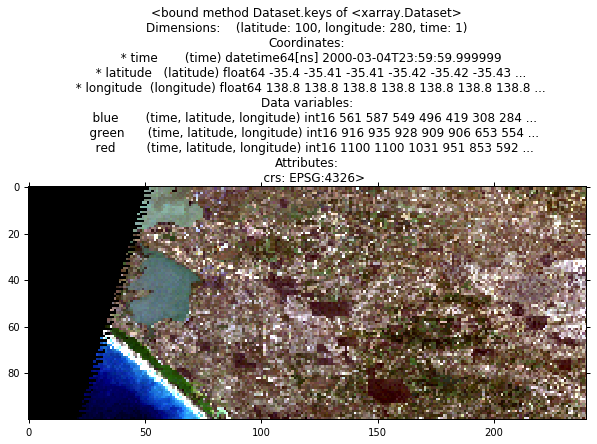

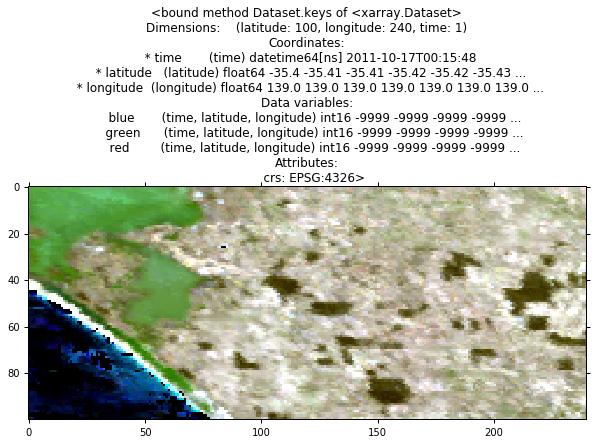

In [188]:
plotlist = []
for product in dc.index.products.get_all():
    
    if product.name in unique_products:

        if product.managed:
            product_name = product.name

            byproduct = rgb_matches.loc[rgb_matches['sensor2'] == product_name]

            red = byproduct.loc[byproduct['sensor1keys'] == 'RED']['sensor2keys'].values[0]
            green = byproduct.loc[byproduct['sensor1keys'] == 'GREEN']['sensor2keys'].values[0]
            blue = byproduct.loc[byproduct['sensor1keys'] == 'BLUE']['sensor2keys'].values[0]
            
            plot_folium([datasets_union(dc.index.datasets.search_eager(product=product_name))])
            
            plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
            plt.title(str(cube.keys))
            cube = dc.load(product=product.name, x=(139, 140.2), y=(-35.9, -35.4), measurements=['blue', 'green', 'red'],\
                           output_crs='EPSG:4326', resolution=(-0.005,0.005))
            
            plt.imshow(plot_rgb(cube, red, green, blue, 0))


In [185]:
plt.close()